# ALS Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lenskit.algorithms.item_knn import ItemItem
from lenskit.metrics import topn as lm
import fastparquet
%matplotlib inline

In [2]:
dataset = 'ml-100k'

## Explicit Parameter Sweep

In [3]:
runs = pd.read_parquet(f'build/sweep-als-{dataset}-runs.parquet')
runs.head()

,AlgoStr,Algorithm,Partition,PredictTime,RecTime,RunId,TrainTime,features,regularization
0,<lenskit.algorithms.basic.Bias object at 0x7ff...,Bias,0,0.220646,0.559057,1,0.045364,NaN,NaN
1,"als.BiasedMF(features=5, regularization=0.01)",BiasedMF,0,0.233390,0.664008,2,2.262248,5.0,0.01
2,"als.BiasedMF(features=5, regularization=0.05)",BiasedMF,0,0.215481,0.576937,3,0.377837,5.0,0.05
3,"als.BiasedMF(features=5, regularization=0.1)",BiasedMF,0,0.215841,0.581723,4,0.369577,5.0,0.10
4,"als.BiasedMF(features=10, regularization=0.01)",BiasedMF,0,0.215986,0.610071,5,0.376599,10.0,0.01


In [13]:
meta = runs.loc[:, ['RunId', 'Algorithm', 'features', 'regularization']]
meta.head()

,RunId,Algorithm,features,regularization
0,1,Bias,NaN,NaN
1,2,BiasedMF,5.0,0.01
2,3,BiasedMF,5.0,0.05
3,4,BiasedMF,5.0,0.10
4,5,BiasedMF,10.0,0.01


### Training Time

In [4]:
train_time = runs.groupby(['features', 'regularization']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean       min       max
features regularization                              
5.0      0.01            0.808229  0.364009  2.262248
         0.05            0.419494  0.365117  0.623619
         0.10            0.412875  0.363714  0.598172
10.0     0.01            0.415219  0.371510  0.580282
         0.05            0.412903  0.376747  0.452592

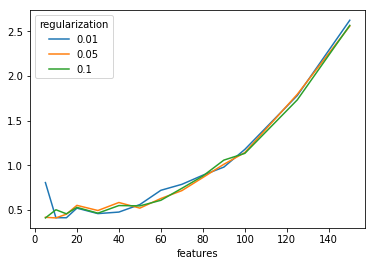

In [5]:
train_time.reset_index().pivot(index='features', columns='regularization', values='mean').plot()

Regularization does not affect training time, but feature count definitely does (as expected).

### Prediction Accuracy

In [7]:
preds = pd.read_parquet(f'build/sweep-als-{dataset}-preds.parquet')
preds.head()

,user,item,rating,timestamp,prediction,RunId
index,,,,,,
10327,6,195,4.0,883602283,3.737012,1
24761,6,293,3.0,883599327,3.607069,1
30997,6,203,3.0,883602864,3.674475,1
32625,6,137,5.0,883599327,3.699557,1
38944,6,194,4.0,883601365,3.858713,1


In [17]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error * preds.error
preds = pd.merge(meta, preds)
mse = preds.groupby(['Algorithm', 'features', 'regularization']).sqerr.mean()
rmse = np.sqrt(mse)
rmse = rmse.reset_index(name='RMSE')
rmse.head()

,Algorithm,features,regularization,RMSE
0,BiasedMF,5.0,0.01,1.076324
1,BiasedMF,5.0,0.05,0.984079
2,BiasedMF,5.0,0.10,0.947909
3,BiasedMF,10.0,0.01,1.227187
4,BiasedMF,10.0,0.05,0.999741


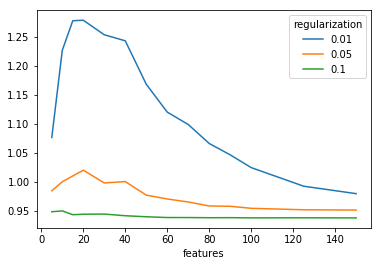

In [18]:
rmse_piv = rmse.pivot(index='features', columns='regularization', values='RMSE')
rmse_piv.plot()

## MF Comparison

In [20]:
runs = pd.read_parquet(f'build/sweep-mf-all-{dataset}-runs.parquet')
runs.head()

,AlgoStr,Algorithm,Partition,PredictTime,RecTime,RunId,TrainTime,features
0,<lenskit.algorithms.basic.Bias object at 0x7ff...,Bias,0,0.230399,0.563657,1,0.045424,NaN
1,<lenskit.algorithms.basic.Popular object at 0x...,Popular,0,0.000086,0.411309,2,0.002355,NaN
2,"als.BiasedMF(features=5, regularization=0.1)",BiasedMF,0,0.225548,0.602917,3,3.539628,5.0
3,"als.BiasedMF(features=10, regularization=0.1)",BiasedMF,0,0.222113,0.619154,4,0.350607,10.0
4,"als.BiasedMF(features=15, regularization=0.1)",BiasedMF,0,0.222651,0.638718,5,0.346339,15.0


In [21]:
meta = runs.loc[:, ['RunId', 'Algorithm', 'features']]
meta.head()

,RunId,Algorithm,features
0,1,Bias,NaN
1,2,Popular,NaN
2,3,BiasedMF,5.0
3,4,BiasedMF,10.0
4,5,BiasedMF,15.0


### Training Time

In [22]:
train_time = runs.groupby(['Algorithm', 'features']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean       min       max
Algorithm features                              
BiasedMF  5.0       0.973399  0.328232  3.539628
          10.0      0.342062  0.329641  0.355733
          15.0      0.339784  0.332901  0.347689
          20.0      0.360299  0.349229  0.375338
          30.0      0.365030  0.357447  0.377560

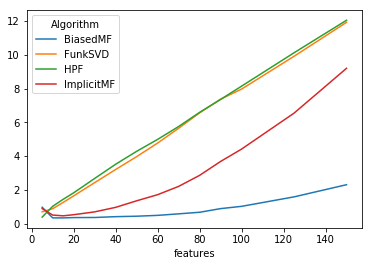

In [23]:
train_time.reset_index().pivot(index='features', columns='Algorithm', values='mean').plot()

### Predictive Accuracy

In [24]:
preds = pd.read_parquet(f'build/sweep-mf-all-{dataset}-preds.parquet')
preds.head()

,user,item,rating,timestamp,prediction,RunId
index,,,,,,
8976,1,12,5.0,878542960,4.422004,1
31376,1,93,5.0,875071484,3.757930,1
5260,1,215,3.0,876893145,3.760604,1
1989,1,90,4.0,878542300,3.123795,1
77630,1,217,3.0,876892676,3.232643,1


In [25]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error.apply(np.square)
run_rmse = preds.groupby('RunId').sqerr.mean().apply(np.sqrt).reset_index(name='RMSE')
run_rmse = pd.merge(meta, run_rmse)
run_rmse.head()

,RunId,Algorithm,features,RMSE
0,1,Bias,NaN,0.982719
1,3,BiasedMF,5.0,0.964616
2,4,BiasedMF,10.0,0.972792
3,5,BiasedMF,15.0,0.958278
4,6,BiasedMF,20.0,0.959178


In [26]:
base_rmse = run_rmse[run_rmse.features.isna()].groupby('Algorithm').RMSE.mean()
base_rmse

Algorithm
Bias    0.972872
Name: RMSE, dtype: float64

In [27]:
cfg_rmse = run_rmse.groupby(['Algorithm', 'features']).RMSE.mean().reset_index()
cfg_rmse = cfg_rmse[cfg_rmse.Algorithm != 'ImplicitMF']
cfg_rmse.head()

,Algorithm,features,RMSE
0,BiasedMF,5.0,0.953772
1,BiasedMF,10.0,0.956486
2,BiasedMF,15.0,0.956091
3,BiasedMF,20.0,0.954708
4,BiasedMF,30.0,0.951548


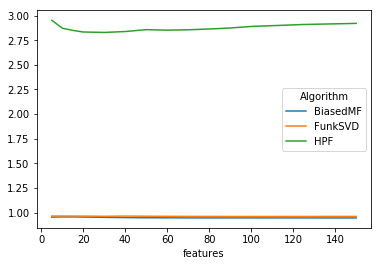

In [28]:
cfg_rmse.pivot(index='features', columns='Algorithm', values='RMSE').plot()

### Top-N Accuracy

In [29]:
recs = pd.read_parquet(f'build/sweep-mf-all-{dataset}-recs.parquet')
recs.head()

,user,rank,item,score,rating,timestamp,RunId
index,,,,,,,
0,1,1,318,4.509118,0.0,NaN,1
1,1,2,483,4.494738,0.0,NaN,1
2,1,3,408,4.492152,0.0,NaN,1
3,1,4,603,4.434120,0.0,NaN,1
4,1,5,12,4.422004,5.0,878542960.0,1


In [30]:
recs.sort_values(['RunId', 'user', 'rank'], inplace=True)

In [31]:
user_ndcg = recs.groupby(['RunId', 'user']).rating.apply(lm.ndcg).reset_index(name='NDCG')
user_ndcg = pd.merge(meta, user_ndcg)
user_ndcg.head()

,RunId,Algorithm,features,user,NDCG
0,1,Bias,NaN,1,0.430677
1,1,Bias,NaN,6,0.179874
2,1,Bias,NaN,7,0.200321
3,1,Bias,NaN,8,0.205808
4,1,Bias,NaN,10,0.329449


In [32]:
base_ndcg = user_ndcg[user_ndcg.features.isna()].groupby('Algorithm').NDCG.mean().reset_index()
base_ndcg.head()

,Algorithm,NDCG
0,Bias,0.158004
1,Popular,0.287940


In [33]:
ndcg = user_ndcg.groupby(['Algorithm', 'features']).NDCG.mean().reset_index()
ndcg.head()

,Algorithm,features,NDCG
0,BiasedMF,5.0,0.137597
1,BiasedMF,10.0,0.151818
2,BiasedMF,15.0,0.154315
3,BiasedMF,20.0,0.155104
4,BiasedMF,30.0,0.160301


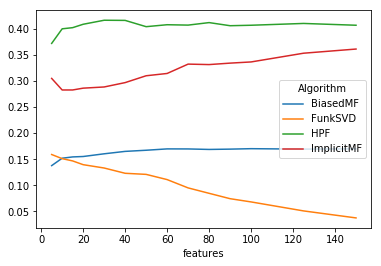

In [34]:
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot()

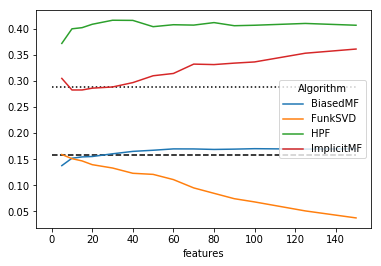

In [35]:
fig, ax = plt.subplots()
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot(ax=ax)
plt.hlines(base_ndcg.NDCG, xmin=0, xmax=150,
           linestyles=['dashed', 'dotted'], label='Baseline')
plt.show()

## Training Study

In [ ]:
epochs = pd.read_csv('build/probe-als-ml-10m.csv')

In [ ]:
epochs.plot.scatter(x='epoch', y='rmse')